# Real-time Deep Learning inference with Essentia, Tensorflow and PyAudio

In [1]:
%matplotlib nbagg

import time
from struct import unpack

import matplotlib.pyplot as plt
import numpy as np
import pyaudio
from IPython import display

from essentia.streaming import *
from essentia import Pool, run, array, reset

ModuleNotFoundError: No module named 'essentia'

In [2]:
# model parameters
modelName = 'msd_frozen_small.pb'
input_layer = 'model/Placeholder'
output_layer = 'model/Sigmoid'
msd_labels = ['rock','pop','alternative','indie','electronic','female vocalists','dance','00s','alternative rock','jazz','beautiful','metal','chillout','male vocalists','classic rock','soul','indie rock','Mellow','electronica','80s','folk','90s','chill','instrumental','punk','oldies','blues','hard rock','ambient','acoustic','experimental','female vocalist','guitar','Hip-Hop','70s','party','country','easy listening','sexy','catchy','funk','electro','heavy metal','Progressive rock','60s','rnb','indie pop','sad','House','happy']

# analysis parameters
sampleRate = 16000
chuncksize = 2**13
frameSize=512 
hopSize=256
patchSize = 15

# mel bands parameters
numberBands=96
weighting='linear'
warpingFormula='slaneyMel'
normalize='unit_tri'

# PyAudio configuration
FORMAT = pyaudio.paFloat32
channels = 1
# in_sr = 44100

##  Essentia algorithms 

In [3]:
# resam = Resample(inputSampleRate=in_sr,
#                  outputSampleRate=sampleRate)

fc = FrameCutter(frameSize=frameSize, hopSize=hopSize, 
                 startFromZero=True,
                 lastFrameToEndOfFile=False)

w = Windowing(normalized=False)

spec = Spectrum()

mel = MelBands(numberBands=numberBands, sampleRate=sampleRate,
               highFrequencyBound=sampleRate // 2, inputSize=frameSize // 2 + 1,
               weighting=weighting, normalize=normalize,
               warpingFormula=warpingFormula)

shift = UnaryOperator(shift=1, scale=10000)

comp = UnaryOperator(type='log10')

vtt = VectorRealToTensor(shape=[1, 1, patchSize, numberBands], lastPatchMode='discard')

ttp = TensorToPool(namespace=input_layer)

tfp = TensorflowPredict(graphFilename=modelName,
                        inputs=[input_layer],
                        outputs=[output_layer],
                        isTrainingName="model/Placeholder_1")

ptt = PoolToTensor(namespace=output_layer)

ttv = TensorToVectorReal()

pool = Pool()

NameError: name 'FrameCutter' is not defined

In [ ]:
# resam.signal   >>  fc.signal
fc.frame       >>  w.frame
w.frame        >>  spec.frame
w.frame        >>  (pool, "frames")
spec.spectrum  >>  mel.spectrum
mel.bands      >>  shift.array
shift.array    >>  comp.array
comp.array     >>  vtt.frame
comp.array     >>  (pool, "melbands")
vtt.tensor     >>  ttp.tensor
ttp.pool       >>  tfp.poolIn
tfp.poolOut    >>  ptt.pool
ptt.tensor     >>  ttv.tensor
ttv.frame      >>  (pool, output_layer)

## Real time processing with PyAudio

Chunks of Audio are generated by PyAudio via this callback

In [6]:
def callback(in_data, frame_count, time_info, status):
    buffer = np.array(unpack('f' * (channels * chuncksize), in_data))
    print(np.shape(buffer))
    # if channels == 2:
    #     buffer = np.mean([buffer[::2], buffer[1::2]], axis=0)

    # vimp = VectorInput(buffer)
    
    # vimp.data >> fc.signal
    # run(vimp)

    # if pool.containsKey('melbands'):
    #     if  pool['melbands'].shape[0] > tokens['mel']:
    #         tokens['mel'] = pool['melbands'].shape[0]
            
    #         if pool['melbands'].shape[0] > patchSize:
    #             data_mel = pool['melbands'][-patchSize:,:].T
    #         else:
    #             data_mel = np.zeros([numberBands, patchSize])
    #             data_mel[:, -pool['melbands'].shape[0]:] = pool['melbands'].T

    #         img_mel.set_data(data_mel)
    #         img_mel.autoscale()
        
    # if pool.containsKey('model/Sigmoid'):
    #     if  pool['model/Sigmoid'].shape[0] > tokens['activations']:
    #         tokens['activations'] = pool['model/Sigmoid'].shape[0]
            
    #         if pool['model/Sigmoid'].shape[0] > 20:
    #             data_acts = pool['model/Sigmoid'][-20:,:].T
    #         else:
    #             data_acts = np.zeros([50, 20])
    #             data_acts[:, -pool['model/Sigmoid'].shape[0]:] = pool['model/Sigmoid'].T

    #         img_act.set_data(data_acts)
    #         img_act.autoscale()

    # f.canvas.draw()
    # f.canvas.flush_events()

    # reset(vimp)
    # vimp.data.disconnect(fc.signal)
    
    # return (in_data, pyaudio.paContinue)

In [7]:
# # initialize plots
# f, ax = plt.subplots(1, 2, figsize=[9.6, 7])
# f.canvas.draw()

# ax[0].set_title('Mel Bands')
# img_mel = ax[0].imshow(np.zeros([numberBands, patchSize]),
#                        aspect='auto', origin='lower')

# ax[1].set_title('Activations')
# img_act = ax[1].matshow(np.zeros([50, 20]), aspect='0.7')
# ax[1].xaxis.set_ticks_position('bottom')
# _ = plt.yticks(np.arange(50), msd_labels, fontsize=6)

# # reset storage and counter
# pool.clear()
# frames = []
# tokens = {'mel': 0, 'activations': 0}

# stream from mic or file
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sampleRate,
                input=True,
                stream_callback=callback,
                frames_per_buffer=chuncksize)

print("* recording")
stream.start_stream()

time.sleep(10)

stream.stop_stream()
stream.close()
p.terminate()

* recording
(8192,)


SystemError: new style getargs format but argument is not a tuple

SystemError: 

## Prcess from a file

In [ ]:
from essentia.standard import MonoLoader


audio = MonoLoader(sampleRate=16000, filename='barry_white-you_heart_and_soul.mp3')()

<IPython.core.display.Javascript object>


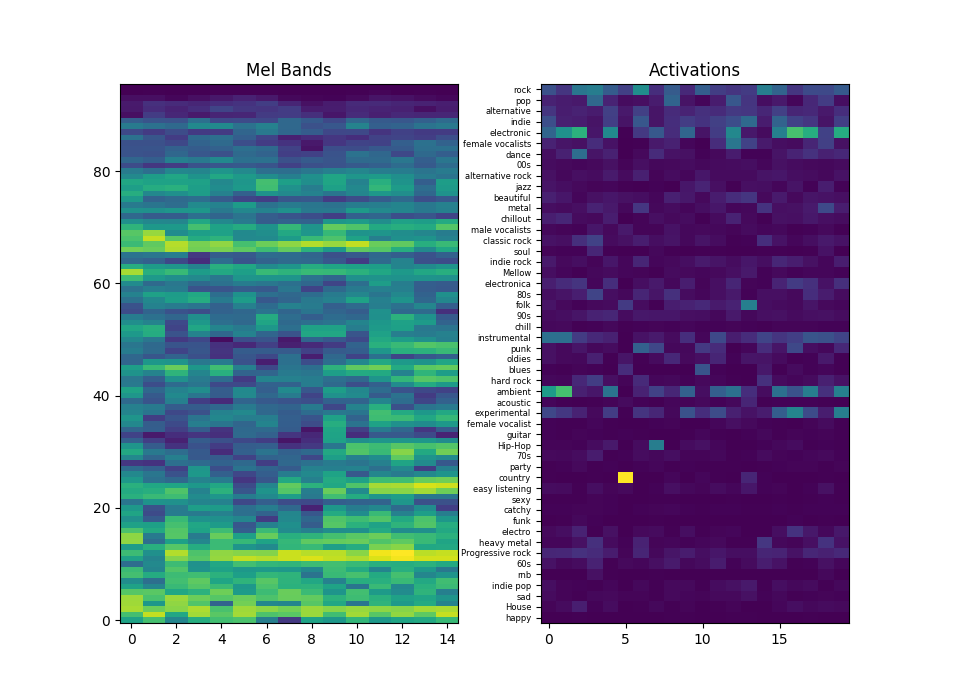

KeyboardInterrupt: 

In [ ]:
# initialize plots
f, ax = plt.subplots(1, 2, figsize=[9.6, 7])
f.canvas.draw()

ax[0].set_title('Mel Bands')
img_mel = ax[0].imshow(np.zeros([numberBands, patchSize]),
                       aspect='auto', origin='lower')

ax[1].set_title('Activations')
img_act = ax[1].matshow(np.zeros([50, 20]), aspect='0.7')
ax[1].xaxis.set_ticks_position('bottom')
_ = plt.yticks(np.arange(50), msd_labels, fontsize=6)

# reset storage and counter
pool.clear()
frames = []
tokens = {'mel': 0, 'activations': 0}

from essentia.standard import FrameGenerator

for chunk in FrameGenerator(audio, frameSize=chuncksize, hopSize=chuncksize):
    callback(chunk, 0, 0, 'e')